### Process:
1. Ensure that we are trading every hour
2. Get live data (3 Data points to account for the data preparation)
3. Append it to csv, ensuring the limit of data points in the csv file (the limit == the train_size for the optimization process)
4. Load the data from the csv file
5. optimize if time to optimize (use optimize_counter)
6. rebalance if time to rebalance (use rebalance_counter)
7. Run the strategy on the dataset
8. On the last time index (the last candle), get the universe (level 2 index) and actual allocation for each coin\
=> Make sure that we have applied self.live = True when initiating the strategy (to not shift the position values)\
(a) If coin not in universe -> Put their allocation\
(b) If actual allocation != shifted allocation, change the allocation of the coin\
--> Changing the allocation of a coin, is by determining the amount in currency = (amount_USD / close_price) to sell or to buy, then placing that order

---

# Strategy Optimization and Portfolio Management

---

## At Boot

1. Get all symbols.
2. Fetch `market_data` (up-to-date data) and trim it to `train_size + test_size` (assuming a constant `step_size` equal to `train_size`).
3. Format symbols to match the exchange (e.g., Kraken).
4. Use `halal_symbols` to get halal data.
5. Save `market_data` to `market_data.csv`.
6. Initialize the `strategy_instances` map (add all strategies into a dictionary).

---

## **For Strategy Optimization**

### When Optimizing

1. Run strategy optimization (not walk-forward optimization) for each strategy to determine `best_params`.
2. Store `best_params` for each strategy in a dictionary for later use.
3. Run each strategy with its `best_params`.

---

## **For Portfolio Management**

### When Optimizing

1. Perform the walk-forward optimization (WFO) process for each strategy using all `market_data` to get results for each strategy.
2. Extract `strategy_returns` from the WFO results for each strategy.
3. Set the `max_allocation` parameter to 1.
4. Run portfolio management on `strategy_returns` to create a new map of selected strategies (on each optimization).
5. Store the `selected_strategy_map` for later use.

---

## **For Portfolio Optimization**

### When Rebalancing

1. Run the WFO process for each selected strategy using all `market_data` to obtain results.
2. Perform portfolio optimization on `strategy_returns` to calculate weights:
   - Use `max_allocation` based on `current_total_balance * weight`.

---

## **For Portfolio Risk Management**

### At Each Time We Loop

1. Run each strategy with its `best_params` on `market_data.csv`:
   - Set `max_allocation = max_allocation / max_positions * current_total_balance * according_weight`.
2. Obtain `strategy_returns` and their weights.
3. Run `calculate_returns()` from portfolio optimization to output `weighted_returns`.
4. Calculate cumulative return (`current_portfolio_returns`) from `weighted_returns`.
5. Perform portfolio risk management on `current_portfolio_returns`:
   - If `True` in the last row of `portfolio_rm`:
     - Check if holding any coins:
       - Liquidate all coins in the portfolio balance.
     - Continue.
   - If `False`, do nothing.

---

## **Taking Positions**

### At Each Time We Loop

1. Update the strategy map with the `max_allocation` for each strategy instance.
2. Fetch the `current_total_balance` of the portfolio from the exchange.
3. Get the latest data using `halal_symbols` and append to `market_data.csv`.
4. Ensure `market_data` length equals `train_size + test_size`.
5. Run each strategy with `best_params` on `market_data.csv`:
   - Update `max_allocation = max_allocation / max_positions * current_total_balance * according_weight`.
6. Obtain the DataFrame for each strategy.
7. Concatenate all strategies' data (`index['coin']`, `current_allocation`).
8. Calculate allocation per coin (as a dictionary mapping allocations to names).
9. Identify `current_universe` (using the last row of `df_strategies`).
10. Determine `current_allocation_coin_currency` for each coin:
    - `df_strategies['current_allocation'] / df_strategies['close']`.
11. Identify `current_held_coin` from the portfolio.
12. Liquidate all coins not in the `current_universe`.
13. For each coin:
    - Fetch its current balance and actual allocation from `df_strategies`.
    - Calculate `position_to_add`.
    - If `position_to_add > 0`, execute a buy signal; otherwise, execute a sell signal.

---

## **Combining Processes**

Processes occurring simultaneously can be combined under a single method to avoid redundancy.

---

## **Initialization Variables**

- `strat_1_instance = ...`
- `strat_2_instance = ...`
- `counter = 0`
- `cash_df = ...`
- `strategy_map = {}`
- `best_params = None`
- `best_weights = None`
- `exchange = ...`
- `halal_symbols = ...`
- `symbols_to_liquidate = None`
- `selected_strategy = None`
- `drawdown_threshold = -0.15`
- `train_size = 440`
- `test_size = 200`
- `step_size = 200`
- `low_corr_thresh = 1`
- `strategy_data_filename = 'strategy_data.csv'`
- `market_data_filename = 'market_data.csv'`
- `max_rows_market_data = market_data_size = 2000`
- `timeframe = '1h'`
- `strategy_optimization_frequency = step_size`
- `portfolio_optimization_frequency = 300`
- `portfolio_management_frequency = 4380` (Every 6 months)

---

## **Execution**

### Before the Main Loop

1. Load `market_data.csv`.

### Main Loop

At the beginning of each hour:
1. Perform optimization: `perform_optimization()`.
2. Perform portfolio optimization: `perform_portfolio_optimization()`.
3. Perform portfolio management: `perform_portfolio_management()`.
4. Perform portfolio risk management: `perform_portfolio_rm()`:
   - Continue if it outputs `True` (indicating a drawdown).
5. Execute strategies: `run_strategy()`.


In [4]:
def symbols_in_current_balance(exchange):
    # Fetch account balance
    try:
        balance = exchange.fetch_balance()
        
        # Extract symbols with non-zero balance
        symbols = [currency + 'USDT' for currency, info in balance['total'].items() if info > 0]
        
        print("Symbols in your current balance:", symbols)
    except ccxt.BaseError as e:
        print(f"An error occurred: {e}")

In [61]:
def buy(to_add, coin, exchange):
    try:
        order = exchange.create_market_buy_order(coin, to_add)
        print(f"Buy order placed: {order}")
    except Exception as e:
        print(f"Error: {e}")

In [6]:
def sell(to_sell, coin, exchange):
    try:
        order = exchange.create_market_sell_order(coin, to_sell)
        print(f"Sell order placed: {order}")
    except Exception as e:
        print(f"Error: {e}")

In [1]:
def liquidate(exchange):
    try:
        # Step 1: Get your balances
        balance = exchange.fetch_balance()
        cant_liquidate = ['USD', 'CAD']

        # Step 2: Loop through all assets in your balance and sell them
        for coin, coin_balance in balance['free'].items():
            if coin not in cant_liquidate:
                if coin_balance > 0:  # Only sell if you have a non-zero balance
                    print(f"Selling {coin_balance} {coin}...")

                    # Determine the symbol for the sell order (e.g., BTC/USD, ETH/USDT)
                    symbol = f"{coin}/USD"  # Replace USD with your preferred quote currency
                    order = exchange.create_market_sell_order(symbol, coin_balance)
                    print(f"Sell order placed: {order}")
                else:
                    print(f"No {coin} to sell.")

        print("All possible assets have been liquidated.")

    except Exception as e:
        print(f"Error: {e}")

In [1]:
import ccxt
import pandas as pd
import numpy as np
import os
import time
from unsync import unsync
import datetime as dt
import sys
from concurrent.futures import ThreadPoolExecutor
import re
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [2]:
# Ensure the directories are in the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Data_Management'))) 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Portfolio_Optimization'))) 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Strategies', 'Trend_Following')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Strategies', 'Mean_Reversion')))

# Import the modules
from data import Data, get_halal_symbols
from fetch_symbols import get_symbols
from sprtrnd_breakout import Sprtrnd_Breakout
from last_days_low import Last_Days_Low
from portfolio_management import Portfolio_Management
from portfolio_optimization import Portfolio_Optimization
from portfolio_risk_management import Portfolio_RM


### At boot

In [11]:
#Connect to exchange
api_key = 'yqPWrtVuElaIExKmIp/E/upTOz/to1x7tC3JoFUxoSTKWCOorT6ifF/B'
api_secret = 'L8h5vYoAu/jpQiBROA9yKN41FGwZAGGVF3nfrC5f5EiaoF7VksruPVdD7x1VOwnyyNCMdrGnT8lP4xHTiBrYMQ=='

exchange = ccxt.kraken({
    'apiKey': api_key,
    'secret': api_secret
})

In [12]:
all_symbols = get_symbols()

In [13]:
train_size = 500
test_size = 500
step_size = 500

In [14]:
start_time = (dt.datetime.now() - dt.timedelta(hours=train_size + test_size + 200)).date()
end_time = dt.datetime.now().date()
timeframes = ['1w', '1d', '4h', '1h', '30m','15m', '5m', '1m']
index = 3 #It is better to choose the highest frequency for the backtest to be able to downsample
interval = timeframes[index]
symbols = ['BTCUSD', 'ETHUSD']
data_instance = Data(symbols, interval, start_time, end_time, exchange = 'kraken', get_data = False)

In [80]:
data = data_instance.get_data()

In [81]:
last_date_data = data.index.get_level_values(0).unique()[-1].tz_localize('UTC')

In [89]:
if dt.datetime.now(dt.UTC).replace(minute=0, second=0, microsecond=0) != last_date_data:
    time_difference = dt.datetime.now(dt.UTC).replace(minute=0, second=0, microsecond=0) - last_date_data
    hours_difference = time_difference.total_seconds() / 3600 # Get the number of hours
    missing_data = fetch_latest_data(all_symbols, interval, limit = int(hours_difference) + 1).result()
    complete_data = pd.concat([data, missing_data])

In [92]:
complete_data.index = complete_data.index.set_levels(pd.to_datetime(complete_data.index.levels[0]), level=0)

In [94]:
complete_data.to_csv('market_data.csv')

Putting all together

In [15]:
def upload_complete_market_data(halal_symbols, data_size = 2200):
    start_time = (dt.datetime.now() - dt.timedelta(hours= data_size)).date()
    end_time = dt.datetime.now().date()
    timeframes = ['1w', '1d', '4h', '1h', '30m','15m', '5m', '1m']
    index = 3 #It is better to choose the highest frequency for the backtest to be able to downsample
    interval = timeframes[index]
    data_instance = Data(halal_symbols, interval, start_time, end_time, exchange = 'kraken')
    data = data_instance.df
    last_date_data = data.index.get_level_values(0).unique()[-1].tz_localize('UTC')
    
    if dt.datetime.now(dt.UTC).replace(minute=0, second=0, microsecond=0) != last_date_data:
        time_difference = dt.datetime.now(dt.UTC).replace(minute=0, second=0, microsecond=0) - last_date_data
        hours_difference = time_difference.total_seconds() / 3600 # Get the number of hours
        missing_data = fetch_latest_data(halal_symbols, interval, limit = int(hours_difference) + 1).result()
        complete_data = pd.concat([data, missing_data])
        
    complete_data.index = complete_data.index.set_levels(pd.to_datetime(complete_data.index.levels[0]), level=0)
    complete_data.to_csv('market_data.csv')
    print('Market data updated successfully')

In [ ]:
upload_complete_market_data(symbols, data_size = (train_size + test_size) * 4)

### At each time we loop

In [231]:
data.index.get_level_values("date").unique()[-1]

Timestamp('2025-01-16 05:00:00')

In [234]:
dt.datetime.now(dt.UTC).date() == data.index.get_level_values("date").unique()[-1].date()

True

In [28]:
#Helper function
def get_last_row(data, check_todays_date = False):
    """Get the last date in the dataset."""
    if check_todays_date:
        last_date = data.index.get_level_values("date").unique()[-1]
        if last_date.date() == dt.datetime.now(dt.UTC).date():
            return data.loc[last_date]
        else:
            return None

In [11]:
def get_portfolio_value(exchange):
    try:
        # Fetch account balances
        balances = exchange.fetch_balance()

        # Fetch tickers to get the latest prices
        tickers = exchange.fetch_tickers()

        # Calculate portfolio value in USD (or another base currency)
        portfolio_value = 0.0

        for currency, balance in balances['total'].items():
            if balance > 0:
                if currency == "USD":
                    # Add USD cash directly to portfolio value
                    portfolio_value += balance
                else:
                    # Use the USD pair or the most liquid market
                    pair = f"{currency}/USD"
                    if pair in tickers:
                        price = tickers[pair]['last']
                        portfolio_value += balance * price
                    else:
                        # Handle currencies without USD pairs (e.g., trade to BTC, then USD)
                        btc_pair = f"{currency}/BTC"
                        if btc_pair in tickers:
                            btc_price = tickers[btc_pair]['last']
                            usd_price = tickers["BTC/USD"]['last']
                            portfolio_value += balance * btc_price * usd_price

        return round(portfolio_value, 2)

    except ccxt.BaseError as e:
        print(f"An error occurred: {str(e)}")
        return None


In [36]:
portfolio_value = get_portfolio_value(exchange)

In [37]:
portfolio_value

33.3

In [30]:
def format_symbols(symbols):
    """Converts the symbols to a format that the exchange understands."""
    if symbols[0].endswith('T'):
        symbols = [s[:-1] for s in symbols]
    formatted_symbols = [symbol.replace("USD", "/USD") for symbol in symbols]
    return formatted_symbols

def filter_halal_df(data):
    # Drop multiple coins
    halal_symbols = ['BTC/USD', 'ETH/USD', 'LTC/USD']
    data_filtered = data[data.index.get_level_values("coin").isin(halal_symbols)]
    return data_filtered

In [ ]:
halal_symbols = get_halal_symbols()

In [ ]:
formatted_halal_symbols = format_symbols(halal_symbols)

In [23]:
@unsync
def fetch_latest_data(symbols, timeframe, limit=2):
    """Fetch latest OHLCV data for multiple symbols and stack them into a single DataFrame."""
    
    formatted_symbols = format_symbols(symbols)
    
    def fetch_symbol_data(symbol, formatted_symbol):
        """Fetch data for a single symbol and return a DataFrame."""
        try:
            ohlcv = exchange.fetch_ohlcv(formatted_symbol, timeframe, limit=limit)
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            df['coin'] = symbol
            return df
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            try:
                # Retry fetching data
                ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
                df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
                df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
                df.set_index('timestamp', inplace=True)
                df['coin'] = symbol
                return df
            except Exception as e:
                print(f"Error fetching data for {symbol} on retry: {e}")
                return pd.DataFrame()

    # Use ThreadPoolExecutor for parallel requests
    with ThreadPoolExecutor(max_workers=16) as executor:  # Adjust workers based on CPU
        results = list(executor.map(fetch_symbol_data, symbols, formatted_symbols))

    # Concatenate all DataFrames and set multi-level index
    data_frames = [df for df in results if not df.empty]
    if data_frames:
        stacked_df = pd.concat(data_frames)
        stacked_df.set_index('coin', append=True, inplace=True)
        stacked_df = stacked_df[~stacked_df.index.duplicated()]  # Remove duplicates
        df = data_instance.prepare_data(stacked_df.unstack())
        df.reset_index(level = 1, inplace = True)
        df['coin'] = df['coin'].str.replace('/USD', 'USDT', regex=False)
        df.set_index('coin', append = True, inplace = True)
        return df
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no data

In [24]:
# Example usage
timeframe = '1h'
latest = fetch_latest_data(symbols, timeframe).result()

In [25]:
latest

close  creturns      high  log_return      low  \
date                coin                                                       
2025-01-16 19:00:00 BTCUSD  99717.0  1.001736  99717.30    0.001734  99454.0   
                    ETHUSD   3327.7  1.000713   3327.99    0.000712   3320.0   

                                open    price   returns     volume  \
date                coin                                             
2025-01-16 19:00:00 BTCUSD  99544.20  99717.0  0.001736  14.083792   
                    ETHUSD   3325.33   3327.7  0.000713  48.168669   

                            volume_in_dollars  
date                coin                       
2025-01-16 19:00:00 BTCUSD       1.404393e+06  
                    ETHUSD       1.602909e+05

In [34]:
# Append new data to CSV and maintain max length (asynchronous)
@unsync
def append_to_csv_with_limit(data, filename, max_rows=2202):
    """_summary_

    Args:
        data (_type_): _description_
        filename (_type_): _description_
        max_rows (int, optional): _description_. Defaults to 2202. Should be account for the max number of rows needed for any of the processes
    """
    file_exists = os.path.isfile(filename)
    df = pd.DataFrame(data)
    
    if file_exists:
        existing_df = pd.read_csv(filename, index_col=[0, 1], parse_dates=['date'])
        print(df.index.get_level_values(0).unique()[-1], existing_df.index.get_level_values(0).unique()[-1])
        if existing_df.index.get_level_values(0).unique()[-1] == latest.index.get_level_values(0).unique()[-1]:
            return
        combined_df = pd.concat([existing_df, df])
        if len(combined_df) > max_rows:
            combined_df = combined_df.iloc[-max_rows:]  # Keep only the last max_rows rows
        combined_df.to_csv(filename)
    else:
        print('File does not exist')
        df.to_csv(filename, mode='w', header=True)


In [35]:
append_to_csv_with_limit(latest, 'market_data.csv', max_rows= (test_size + train_size) * 4).result()

In [12]:
#Getting the data from csv
def load_data_from_csv(filename, train_size = 500, test_size = 500):
    if os.path.isfile(filename):
        data = pd.read_csv(filename, index_col=['date', 'coin'], parse_dates=['date'])
        if len(data) >= train_size + test_size:
            return data
        else:
            print('Data is not enough')
            return pd.DataFrame()
    else:
        print('File does not exist')
        return pd.DataFrame()

In [13]:
data = load_data_from_csv('market_data.csv')

In [14]:
data

close  creturns       high  log_return  \
date                coin                                                  
2024-10-25 01:00:00 BTCUSDT   67969.70  0.999712   68010.01   -0.000288   
                    ETHUSDT    2519.50  0.997778    2527.22   -0.002224   
2024-10-25 02:00:00 BTCUSDT   68066.99  1.001143   68080.00    0.001430   
                    ETHUSDT    2522.40  0.998927    2524.80    0.001150   
2024-10-25 03:00:00 BTCUSDT   68008.00  1.000275   68234.34   -0.000867   
...                                ...       ...        ...         ...   
2025-01-16 21:00:00 ETHUSDT    3318.56  0.961503    3337.02   -0.005574   
2025-01-16 22:00:00 BTCUSDT   99810.00  0.993170  100120.10   -0.003133   
                    ETHUSDT    3295.59  0.954848    3318.56   -0.006946   
2025-01-16 23:00:00 BTCUSDT  100005.70  0.995117  100005.80    0.001959   
                    ETHUSDT    3304.85  0.957531    3304.86    0.002806   

                                  low       open      price   returns  \
date                coin                                                
2024-10-25 01:00:00 BTCUSDT  67845.01   67989.26   67969.70 -0.000288   
                    ETHUSDT   2514.57    2525.09    2519.50 -0.002222   
2024-10-25 02:00:00 BTCUSDT  67836.00   67969.70   68066.99  0.001431   
                    ETHUSDT   2509.89    2519.49    2522.40  0.001151   
2024-10-25 03:00:00 BTCUSDT  67989.55   68066.99   68008.00 -0.000867   
...                               ...        ...        ...       ...   
2025-01-16 21:00:00 ETHUSDT   3312.14    3336.79    3318.56 -0.005559   
2025-01-16 22:00:00 BTCUSDT  99325.90  100120.10   99810.00 -0.003128   
                    ETHUSDT   3269.65    3318.55    3295.59 -0.006922   
2025-01-16 23:00:00 BTCUSDT  99738.00   99810.00  100005.70  0.001961   
                    ETHUSDT   3295.23    3295.60    3304.85  0.002810   

                                  volume  volume_in_dollars  
date                coin                                     
2024-10-25 01:00:00 BTCUSDT   508.337580       3.455155e+07  
                    ETHUSDT  6079.862400       1.531821e+07  
2024-10-25 02:00:00 BTCUSDT   478.050390       3.253945e+07  
                    ETHUSDT  6759.621000       1.705047e+07  
2024-10-25 03:00:00 BTCUSDT   513.745260       3.493879e+07  
...                                  ...                ...  
2025-01-16 21:00:00 ETHUSDT   215.127102       7.139122e+05  
2025-01-16 22:00:00 BTCUSDT    56.614231       5.650666e+06  
                    ETHUSDT  1093.053061       3.602255e+06  
2025-01-16 23:00:00 BTCUSDT     5.727873       5.728200e+05  
                    ETHUSDT    56.989703       1.883424e+05  

[4030 rows x 10 columns]

### Portfolio Management

Should be ran every time we want to optimize

In [16]:
train_size = 500
test_size = 500
step_size = 500

In [17]:
mr_strat_1 = Last_Days_Low(data, objective = 'multiple', train_size = train_size, test_size = test_size, step_size = step_size)
tf_strat_1 = Sprtrnd_Breakout(data, objective = 'multiple', train_size = train_size, test_size = test_size, step_size = step_size)

#Create a dummy results that represents holding cash where the value of the portfolio is constant
cash_df = pd.DataFrame(data = {'strategy': np.zeros(data.shape[0]), 'portfolio_value': np.ones(data.shape[0])}, index = data.index)

strategy_map = {'cash_strat': cash_df,
                'mr_strat_1': mr_strat_1,
                'tf_strat_1': tf_strat_1}

In [11]:
mr_strat_1.test()

Train: 2024-10-25 01:00:00 - 2024-11-14 20:00:00
Test: 2024-11-14 21:00:00 - 2024-12-05 16:00:00
Train: 2024-11-14 21:00:00 - 2024-12-05 16:00:00
Test: 2024-12-05 17:00:00 - 2024-12-26 12:00:00
Performing Last Days Low Strategy
length of data: 1000
Data:                                 close  creturns      high  log_return  \
date                coin                                                
2024-10-25 01:00:00 BTCUSDT  67969.70  0.999712  68010.01   -0.000288   
                    ETHUSDT   2519.50  0.997778   2527.22   -0.002224   
2024-10-25 02:00:00 BTCUSDT  68066.99  1.001143  68080.00    0.001430   
                    ETHUSDT   2522.40  0.998927   2524.80    0.001150   
2024-10-25 03:00:00 BTCUSDT  68008.00  1.000275  68234.34   -0.000867   
...                               ...       ...       ...         ...   
2024-11-14 18:00:00 ETHUSDT   3132.18  1.240413   3143.85    0.000591   
2024-11-14 19:00:00 BTCUSDT  89463.99  1.315855  89664.19    0.003947   
               

<Axes: xlabel='date,coin'>

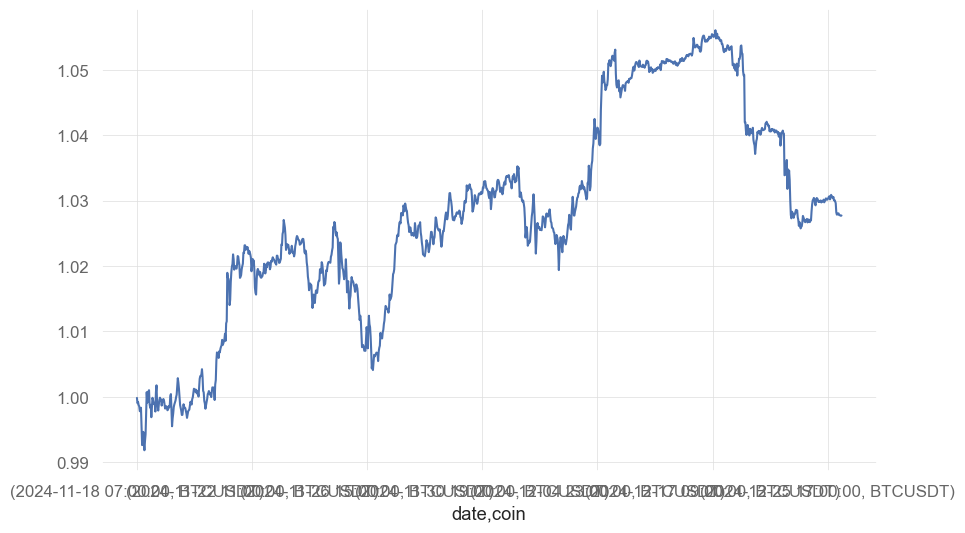

In [12]:
mr_strat_1.results.cstrategy.plot()

In [13]:
tf_strat_1.test()

Train: 2024-10-25 01:00:00 - 2024-11-14 20:00:00
Test: 2024-11-14 21:00:00 - 2024-12-05 16:00:00
Performing Supertrend Breakout Strategy
length of data: 1000
Data:                                 close  creturns      high  log_return  \
date                coin                                                
2024-10-25 01:00:00 BTCUSDT  67969.70  0.999712  68010.01   -0.000288   
                    ETHUSDT   2519.50  0.997778   2527.22   -0.002224   
2024-10-25 02:00:00 BTCUSDT  68066.99  1.001143  68080.00    0.001430   
                    ETHUSDT   2522.40  0.998927   2524.80    0.001150   
2024-10-25 03:00:00 BTCUSDT  68008.00  1.000275  68234.34   -0.000867   
...                               ...       ...       ...         ...   
2024-11-14 18:00:00 ETHUSDT   3132.18  1.240413   3143.85    0.000591   
2024-11-14 19:00:00 BTCUSDT  89463.99  1.315855  89664.19    0.003947   
                    ETHUSDT   3145.41  1.245653   3149.00    0.004215   
2024-11-14 20:00:00 BTCUSDT  8761

<Axes: xlabel='date,None'>

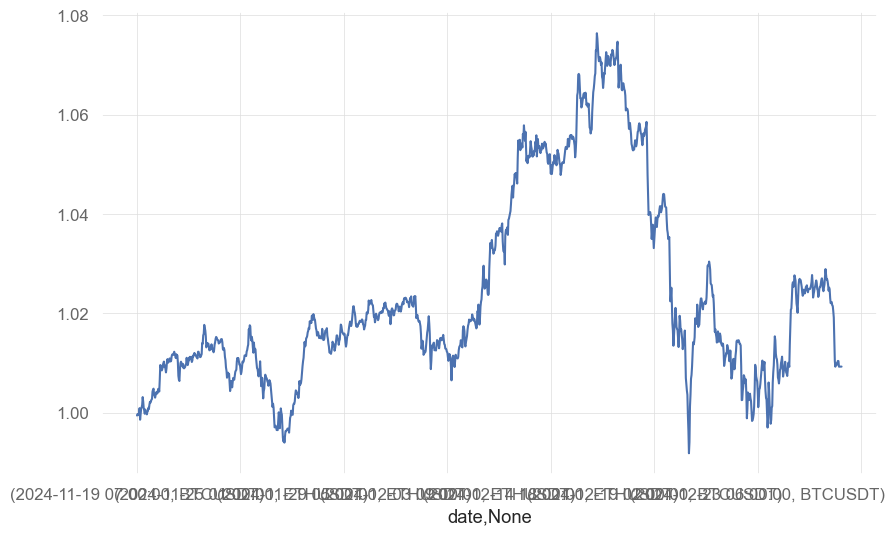

In [14]:
tf_strat_1.results.cstrategy.plot()

In [ ]:
#Run the WFO for each strategy (but the cash strategy)
for key, value in strategy_map.items():
    if key != 'cash_strat':
        print(key)

In [ ]:
#Run the WFO for each strategy (but the cash strategy)
for key, value in strategy_map.items():
    if key != 'cash_strat':
        value.test()

In [ ]:
#Make a new dictionary that contains the results strategy returns of the WFO
results_strategy_returns = {}
for key, value in strategy_map.items():
    if key != 'cash_strat':
        results_strategy_returns[key] = value.results.strategy
    elif key == 'cash_strat':
        results_strategy_returns[key] = value.strategy

In [73]:
portfolio_management = Portfolio_Management(results_strategy_returns)

In [74]:
keys_for_selected_strategy = portfolio_management.filter_by_correlation(low_corr_threshold=1).columns

In [75]:
selected_strategy = {key: value for key, value in strategy_map.items() if key in keys_for_selected_strategy}

Putting All together

In [15]:
def run_wfo_and_get_results_returns(strategy_map):
    """_summary_
    Takes the strategy map, runs the WFO for each strategy and returns the results of the strategy returns after the WFO.
    It also adds the df of the strategy returns to a csv file

    Args:
        strategy_map (_type_): _description_

    Returns:
        results_strategy_returns (_type_): _description_ the results of the strategy returns after the WFO
    """
    #Run the WFO for each strategy (but the cash strategy)
    for key, value in strategy_map.items():
        if key != 'cash_strat':
            value.test()
            
    #Make a new dictionary that contains the results strategy returns of the WFO
    results_strategy_returns = {}
    for key, value in strategy_map.items():
        if key != 'cash_strat':
            results_strategy_returns[key] = value.results.strategy
        elif key == 'cash_strat':
            results_strategy_returns[key] = value.strategy
            
    #Get the strategy returns df
    strategy_returns_df = pd.concat(results_strategy_returns, axis = 1).fillna(0)
    strategy_returns_df.to_csv('strategy_returns.csv')
    
    return results_strategy_returns

In [25]:
def perform_portfolio_management(strategy_map, low_corr_threshold = 1):
    """_summary_

    Args:
        strategy_map (_type_): _description_
        low_corr_threshold (int, optional): _description_. Defaults to 1.
    """
    results_strategy_returns = run_wfo_and_get_results_returns(strategy_map)

    portfolio_management = Portfolio_Management(results_strategy_returns)

    keys_for_selected_strategy = portfolio_management.filter_by_correlation(low_corr_threshold=low_corr_threshold).columns

    selected_strategy = {key: value for key, value in strategy_map.items() if key in keys_for_selected_strategy}

    return selected_strategy

In [26]:
selected_strategy = perform_portfolio_management(strategy_map)

Train: 2024-09-30 01:00:00 - 2024-10-18 08:00:00
Test: 2024-10-18 09:00:00 - 2024-10-26 16:00:00
Train: 2024-10-08 09:00:00 - 2024-10-26 16:00:00
Test: 2024-10-26 17:00:00 - 2024-11-04 00:00:00
length of data: 880
length of data: 880
Train: 2024-10-16 17:00:00 - 2024-11-04 00:00:00
Test: 2024-11-04 01:00:00 - 2024-11-12 08:00:00
length of data: 880
Train: 2024-10-25 01:00:00 - 2024-11-12 08:00:00
Test: 2024-11-12 09:00:00 - 2024-11-20 16:00:00
length of data: 880
Train: 2024-11-02 09:00:00 - 2024-11-20 16:00:00
Test: 2024-11-20 17:00:00 - 2024-11-29 00:00:00
Train: 2024-11-10 17:00:00 - 2024-11-29 00:00:00
Test: 2024-11-29 01:00:00 - 2024-12-07 08:00:00
length of data: 880
length of data: 880
Train: 2024-11-19 01:00:00 - 2024-12-07 08:00:00
Test: 2024-12-07 09:00:00 - 2024-12-15 16:00:00
length of data: 880
Train: 2024-11-27 09:00:00 - 2024-12-15 16:00:00
Test: 2024-12-15 17:00:00 - 2024-12-24 00:00:00
length of data: 880Train: 2024-12-05 17:00:00 - 2024-12-24 00:00:00
Test: 2024-12-24

### Strategy Optimization

In [12]:
counter_opt = 0
counter_reb = 0

In [ ]:
#Run the optimization to get the strategy parameters
for key, value in strategy_map.items():
    if key != 'cash_strat':
        value.optimize()

In [12]:
#Storing the best_params for each strategy in a separate dictionary
best_params = {key: value.best_params for key, value in strategy_map.items() if key != 'cash_strat'}

In [ ]:
best_params

Putting all together

In [ ]:
counter_opt = 0
counter_reb = 0 

In [12]:
def perform_optimization(strategy_map):
    """_summary_

    Args:
        strategy_map (_type_): _description_
    """

    #Run the optimization to get the strategy parameters
    for key, value in strategy_map.items():
        if key != 'cash_strat':
            value.optimize()

    #Storing the best_params for each strategy in a separate dictionary
    best_params = {key: value.best_params for key, value in strategy_map.items() if key != 'cash_strat'}

    return best_params

In [13]:
data

close  creturns      high  log_return  \
date                coin                                                
2024-11-30 10:00:00 ETHUSDT   3641.79  1.374945   3692.55   -0.013693   
2024-11-30 11:00:00 BTCUSDT  96267.99  1.470552  96444.00    0.001357   
                    ETHUSDT   3653.69  1.379438   3663.26    0.003262   
2024-11-30 12:00:00 BTCUSDT  96553.23  1.474909  96563.98    0.002959   
                    ETHUSDT   3681.60  1.389975   3681.81    0.007610   
...                               ...       ...       ...         ...   
2025-01-15 05:00:00 BTCUSDT  96885.50  1.003370  97175.10   -0.002779   
                    ETHUSDT   3224.24  1.000469   3226.50   -0.000698   
2025-01-16 05:00:00 BTCUSD   99495.00  0.998917  99603.00   -0.001084   
                    ETHUSD    3372.09  0.999469   3374.99   -0.000531   
                    LTCUSD     118.74  1.002533    119.29    0.002530   

                                  low      open     price   returns  \
date                coin                                              
2024-11-30 10:00:00 ETHUSDT   3636.87   3692.00   3641.79 -0.013600   
2024-11-30 11:00:00 BTCUSDT  96092.01  96137.48  96267.99  0.001358   
                    ETHUSDT   3631.23   3641.79   3653.69  0.003268   
2024-11-30 12:00:00 BTCUSDT  96242.14  96267.99  96553.23  0.002963   
                    ETHUSDT   3652.63   3653.68   3681.60  0.007639   
...                               ...       ...       ...       ...   
2025-01-15 05:00:00 BTCUSDT  96765.70  97155.10  96885.50 -0.002775   
                    ETHUSDT   3216.51   3226.50   3224.24 -0.000697   
2025-01-16 05:00:00 BTCUSD   99365.60  99603.00  99495.00 -0.001083   
                    ETHUSD    3367.71   3373.99   3372.09 -0.000531   
                    LTCUSD     117.89    118.14    118.74  0.002533   

                                   volume  volume_in_dollars  
date                coin                                      
2024-11-30 10:00:00 ETHUSDT  25967.545400       9.456835e+07  
2024-11-30 11:00:00 BTCUSDT    527.285920       5.076076e+07  
                    ETHUSDT  16956.702600       6.195453e+07  
2024-11-30 12:00:00 BTCUSDT    419.013730       4.045713e+07  
                    ETHUSDT  14350.006400       5.283098e+07  
...                                   ...                ...  
2025-01-15 05:00:00 BTCUSDT     11.885451       1.151528e+06  
                    ETHUSDT     60.258220       1.942870e+05  
2025-01-16 05:00:00 BTCUSD      10.893224       1.083821e+06  
                    ETHUSD     106.270130       3.583524e+05  
                    LTCUSD    1164.425961       1.382639e+05  

[2202 rows x 10 columns]

In [14]:
best_params = perform_optimization(strategy_map)

length of data: 500
Signal Generated
Position Initialized
Stop Loss Applied
Take Profit Applied
Partial Take Profit Applied
Position Calculated
Manage Trade Applied
All Updated
Costs Applied
Data Downsampled
Coarse Analysis Done
Fine Analysis Done


KeyboardInterrupt: 

### Portfolio Optimization

In [ ]:
#Run the WFO for each strategy (but the cash strategy)
for key, value in strategy_map.items():
    if key != 'cash_strat':
        value.test()

In [41]:
#Make a new dictionary that contains the results strategy returns of the WFO
results_strategy_returns = {}
for key, value in strategy_map.items():
    if key != 'cash_strat':
        results_strategy_returns[key] = value.results.strategy
    elif key == 'cash_strat':
        results_strategy_returns[key] = value.strategy

In [42]:
#Get the strategy returns df
strategy_returns_df = pd.concat(results_strategy_returns, axis = 1).fillna(0)

In [43]:
strategy_returns_df

cash_strat  mr_strat_1  tf_strat_1
date                                                           
2024-09-30 01:00:00 BTCUSDT         0.0         0.0         0.0
                    ETHUSDT         0.0         0.0         0.0
2024-09-30 02:00:00 BTCUSDT         0.0         0.0         0.0
                    ETHUSDT         0.0         0.0         0.0
2024-09-30 03:00:00 BTCUSDT         0.0         0.0         0.0
...                                 ...         ...         ...
2025-01-15 03:00:00 ETHUSDT         0.0         0.0         0.0
2025-01-15 04:00:00 BTCUSDT         0.0         0.0         0.0
                    ETHUSDT         0.0         0.0         0.0
2025-01-15 05:00:00 BTCUSDT         0.0         0.0         0.0
                    ETHUSDT         0.0         0.0         0.0

[5146 rows x 3 columns]

In [ ]:
if step_size + train_size + test_size > len(results_strategy_returns):
    raise ValueError("Invalid train, test, or step size.")

In [48]:
#Get portfolio optimization instance
portfolio_optimization_instance = Portfolio_Optimization(log_rets = results_strategy_returns, train_size = 200, test_size = 200, step_size = 200, objective = 'multiple')

ValueError: Invalid train, test, or step size.

In [ ]:
#Run the optimization
train_data = strategy_returns_df.iloc[-train_size:]
train_data

In [ ]:
best_weights = portfolio_optimization_instance.optimize_weights_minimize(train_data)
best_weights

Putting all together

In [16]:
def perform_portfolio_optimization(strategy_map, train_size = 1000, test_size = 1000, step_size = 1000):
    """_summary_

    Args:
        strategy_returns_df (_type_): _description_
        train_size (int, optional): _description_. Defaults to 1000.
        test_size (int, optional): _description_. Defaults to 1000.
        step_size (int, optional): _description_. Defaults to 1000.
    """
    results_strategy_returns = run_wfo_and_get_results_returns(strategy_map)
    
    #Get portfolio optimization instance
    portfolio_optimization_instance = Portfolio_Optimization(log_rets = results_strategy_returns, train_size = train_size, test_size = test_size, step_size = step_size, objective = 'multiple')\

    #Run the optimization
    results_strategy_returns_df = pd.concat(results_strategy_returns, axis = 1).fillna(0)
    train_data = results_strategy_returns_df.iloc[-train_size:]
    best_weights = portfolio_optimization_instance.optimize_weights_minimize(train_data)

    return best_weights

In [ ]:
best_weights = perform_portfolio_optimization(strategy_map, train_size, test_size, step_size)

Train: 2024-10-25 01:00:00 - 2024-11-14 20:00:00
Test: 2024-11-14 21:00:00 - 2024-12-05 16:00:00
Performing Last Days Low Strategy
length of data: 1000
Data:                                 close  creturns      high  log_return  \
date                coin                                                
2024-10-25 01:00:00 BTCUSDT  67969.70  0.999712  68010.01   -0.000288   
                    ETHUSDT   2519.50  0.997778   2527.22   -0.002224   
2024-10-25 02:00:00 BTCUSDT  68066.99  1.001143  68080.00    0.001430   
                    ETHUSDT   2522.40  0.998927   2524.80    0.001150   
2024-10-25 03:00:00 BTCUSDT  68008.00  1.000275  68234.34   -0.000867   
...                               ...       ...       ...         ...   
2024-11-14 18:00:00 ETHUSDT   3132.18  1.240413   3143.85    0.000591   
2024-11-14 19:00:00 BTCUSDT  89463.99  1.315855  89664.19    0.003947   
                    ETHUSDT   3145.41  1.245653   3149.00    0.004215   
2024-11-14 20:00:00 BTCUSDT  87612.66  

### Portfolio Risk Management

In [20]:
#Get the current_total_balance
current_total_balance = get_portfolio_value(exchange)
current_total_balance

33.3

In [24]:
best_params = {'mr_strat_1':{'std_window': 23, 'mean_window': 8, 'ema_window': 47, 'hourly_lookback': 2, 'daily_lookback': 5, '_min_pos': 0.3565276673865839, '_max_pos': 0.8449133579645757, 'sl_ind_length': 36, 'sl_ind_mult': 1.1269915448264407, 'tp_mult': 5, 'ptp_mult': 1.5398410913016733, 'ptp_exit_percent': 0.2827551022612925},
    'tf_strat_1':  {'std_window': 7, 'mean_window': 20, 'ema_window': 41, 'str_length': 49, 'str_mult': 3, '_min_pos': 0.6449553050522405, '_max_pos': 1.0204613078816698, 'sl_ind_length': 25, 'sl_ind_mult': 0.5596923252193994, 'tp_mult': 7, 'ptp_mult': 1.5632882178455394, 'ptp_exit_percent': 0.4468748522859246}}

In [25]:
best_weights = [0, 0.5, 0.5]

In [26]:
#Store the max allocation for each strategy in a dictionary
max_allocation_map = {
    key: best_weights[i] * current_total_balance / strategy.max_universe
    for i, (key, strategy) in enumerate(strategy_map.items())
    if i < len(best_weights) and best_weights[i] > 0 and key != 'cash_strat'
}

max_allocation_map

{'mr_strat_1': 4.1625, 'tf_strat_1': 4.1625}

In [28]:
#Rebuild the strategy map, with the updated max_allocation for each strategy
for key, value in strategy_map.items():
    if key != 'cash_strat':
        value.max_dollar_allocation = max_allocation_map[key]

In [29]:
step_size = 500

In [ ]:
trading_strat_data = mr_strat_1.trading_strategy(data, best_params['mr_strat_1'])
trading_strat_data

length of data: 5146
Signal Generated
Position Initialized
Stop Loss Applied
Take Profit Applied
Partial Take Profit Applied
Position Calculated
Manage Trade Applied
All Updated
Costs Applied
Data Downsampled
Coarse Analysis Done
Fine Analysis Done
Universe Updated
In Universe


,,close,creturns,high,log_return,low,open,price,returns,volume,volume_in_dollars,...,htf_close,htf_volume,htf_volume_in_dollars,volume_flag,volume_rank,htf_std_values,std_rank,ema_79,above_ema,in_universe
date,coin,,,,,,,,,,,,,,,,,,,,,
2024-10-14 17:00:00,BTCUSDT,65640.01,1.002691,65846.00,-0.000974,65459.00,65703.99,65640.01,-0.000974,1061.53508,6.967917e+07,...,66083.99,37669.95222,2.452614e+09,1,2.0,0.022287,2.0,63238.174317,1,True
2024-10-14 18:00:00,BTCUSDT,65769.59,1.004670,65960.00,0.001972,65579.90,65640.00,65769.59,0.001974,978.39321,6.434852e+07,...,66083.99,37669.95222,2.452614e+09,1,2.0,0.021199,2.0,63301.459709,1,True
2024-10-14 19:00:00,BTCUSDT,65939.40,1.007264,66072.30,0.002579,65723.40,65769.59,65939.40,0.002582,1385.23734,9.134172e+07,...,66083.99,37669.95222,2.452614e+09,1,2.0,0.019855,2.0,63367.408216,1,True
2024-10-14 21:00:00,BTCUSDT,65782.14,1.004862,65999.00,-0.002184,65730.00,65925.98,65782.14,-0.002182,396.51022,2.608329e+07,...,66083.99,37669.95222,2.452614e+09,1,2.0,0.016130,2.0,63490.141454,1,True
2024-10-14 22:00:00,BTCUSDT,66454.00,1.015125,66500.00,0.010162,65770.00,65782.14,66454.00,0.010213,1948.67266,1.294971e+08,...,66083.99,37669.95222,2.452614e+09,1,2.0,0.013466,2.0,63564.237918,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 17:00:00,ETHUSDT,3363.42,1.269848,3410.66,-0.013349,3330.00,3408.63,3363.42,-0.013260,28059.32130,9.437528e+07,...,3337.78,303053.16850,1.024269e+09,1,1.0,0.003303,2.0,3380.068258,0,True
2024-12-31 18:00:00,ETHUSDT,3361.37,1.269074,3373.18,-0.000610,3350.22,3363.42,3361.37,-0.000609,12628.02100,4.244745e+07,...,3337.78,303053.16850,1.024269e+09,1,1.0,0.003142,2.0,3379.600801,0,True
2024-12-31 19:00:00,ETHUSDT,3355.38,1.266812,3368.25,-0.001784,3343.77,3361.36,3355.38,-0.001782,5911.09610,1.983397e+07,...,3337.78,303053.16850,1.024269e+09,1,1.0,0.002943,2.0,3378.995281,0,True


In [63]:
len(trading_strat_data)

203

In [64]:
trading_strat_data_2 = tf_strat_1.trading_strategy(data, best_params['tf_strat_1'])
trading_strat_data_2

length of data: 5146
Signal Generated
Position Initialized
Stop Loss Applied
Take Profit Applied
Partial Take Profit Applied
Position Calculated
Manage Trade Applied
All Updated
Costs Applied
Data Downsampled
Coarse Analysis Done
Fine Analysis Done
Universe Updated
In Universe


close  creturns      high  log_return  \
date                                                                    
2024-10-08 15:00:00 BTCUSDT  62288.01  0.951487  62850.24   -0.007836   
                    ETHUSDT   2419.50  0.913474   2441.48   -0.006550   
2024-10-08 16:00:00 BTCUSDT  62570.00  0.955795  62598.00    0.004517   
                    ETHUSDT   2446.00  0.923479   2450.00    0.010893   
2024-10-08 17:00:00 BTCUSDT  62393.94  0.953105  62570.00   -0.002818   
...                               ...       ...       ...         ...   
2025-01-15 03:00:00 ETHUSDT   3236.99  1.004425   3236.99    0.007847   
2025-01-15 04:00:00 BTCUSDT  97155.10  1.006162  97600.00   -0.000461   
                    ETHUSDT   3226.49  1.001167   3248.37   -0.003249   
2025-01-15 05:00:00 BTCUSDT  96885.50  1.003370  97175.10   -0.002779   
                    ETHUSDT   3224.24  1.000469   3226.50   -0.000698   

                                  low      open     price   returns  \
date                                                                  
2024-10-08 15:00:00 BTCUSDT  61864.89  62778.00  62288.01 -0.007805   
                    ETHUSDT   2401.18   2435.40   2419.50 -0.006529   
2024-10-08 16:00:00 BTCUSDT  62023.42  62288.01  62570.00  0.004527   
                    ETHUSDT   2411.17   2419.49   2446.00  0.010953   
2024-10-08 17:00:00 BTCUSDT  62071.31  62569.99  62393.94 -0.002814   
...                               ...       ...       ...       ...   
2025-01-15 03:00:00 ETHUSDT   3207.43   3211.69   3236.99  0.007877   
2025-01-15 04:00:00 BTCUSDT  97100.00  97200.00  97155.10 -0.000461   
                    ETHUSDT   3222.31   3236.99   3226.49 -0.003244   
2025-01-15 05:00:00 BTCUSDT  96765.70  97155.10  96885.50 -0.002775   
                    ETHUSDT   3216.51   3226.50   3224.24 -0.000697   

                                   volume  volume_in_dollars  ...  htf_close  \
date                                                          ...              
2024-10-08 15:00:00 BTCUSDT   2548.140240       1.587186e+08  ...   62160.49   
                    ETHUSDT  29438.432400       7.122629e+07  ...    2440.89   
2024-10-08 16:00:00 BTCUSDT    889.569340       5.566035e+07  ...   62160.49   
                    ETHUSDT  12232.195800       2.991995e+07  ...    2440.89   
2024-10-08 17:00:00 BTCUSDT    716.718010       4.471886e+07  ...   62160.49   
...                                   ...                ...  ...        ...   
2025-01-15 03:00:00 ETHUSDT    575.363653       1.862446e+06  ...    3224.24   
2025-01-15 04:00:00 BTCUSDT     54.336455       5.279064e+06  ...   96885.50   
                    ETHUSDT    175.828958       5.673104e+05  ...    3224.24   
2025-01-15 05:00:00 BTCUSDT     11.885451       1.151528e+06  ...   96885.50   
                    ETHUSDT     60.258220       1.942870e+05  ...    3224.24   

                                htf_volume  htf_volume_in_dollars  \
date                                                                
2024-10-08 15:00:00 BTCUSDT   19702.223710           1.231795e+09   
                    ETHUSDT  201358.331200           4.904155e+08   
2024-10-08 16:00:00 BTCUSDT   19702.223710           1.231795e+09   
                    ETHUSDT  201358.331200           4.904155e+08   
2024-10-08 17:00:00 BTCUSDT   19702.223710           1.231795e+09   
...                                    ...                    ...   
2025-01-15 03:00:00 ETHUSDT    1539.322589           4.967941e+06   
2025-01-15 04:00:00 BTCUSDT     224.317432           2.177102e+07   
                    ETHUSDT    1539.322589           4.967941e+06   
2025-01-15 05:00:00 BTCUSDT     224.317432           2.177102e+07   
                    ETHUSDT    1539.322589           4.967941e+06   

                             volume_flag  volume_rank  htf_std_values  \
date                                                                    
2024-10-08 15:00:00 BTCUSDT            1          2.0        0.000383   


In [65]:
len(trading_strat_data_2)

4734

In [31]:
#Run each strategy on enough data points and get the total portfolio value
length_of_data_to_run_strategy = 2000 #This is because we are going to be using the parameters that were optimized on the last step
    #And thus taking into account the data with the same parameters of a previoused optimized period would be incorrect because markets may have changed
data_to_run_strategy = data.iloc[-length_of_data_to_run_strategy:]

current_strategy_returns = {
    key: value.trading_strategy(data, best_params[key])['strategy']
    for key, value in strategy_map.items()
    if key != 'cash_strat'
}

Performing Last Days Low Strategy
length of data: 4030
Data:                                  close  creturns       high  log_return  \
date                coin                                                  
2024-10-25 01:00:00 BTCUSDT   67969.70  0.999712   68010.01   -0.000288   
                    ETHUSDT    2519.50  0.997778    2527.22   -0.002224   
2024-10-25 02:00:00 BTCUSDT   68066.99  1.001143   68080.00    0.001430   
                    ETHUSDT    2522.40  0.998927    2524.80    0.001150   
2024-10-25 03:00:00 BTCUSDT   68008.00  1.000275   68234.34   -0.000867   
...                                ...       ...        ...         ...   
2025-01-16 21:00:00 ETHUSDT    3318.56  0.961503    3337.02   -0.005574   
2025-01-16 22:00:00 BTCUSDT   99810.00  0.993170  100120.10   -0.003133   
                    ETHUSDT    3295.59  0.954848    3318.56   -0.006946   
2025-01-16 23:00:00 BTCUSDT  100005.70  0.995117  100005.80    0.001959   
                    ETHUSDT    3304.85 

In [32]:
current_strategy_returns['cash_strat'] = cash_df['strategy']

In [35]:
current_strategy_returns_df = pd.concat(current_strategy_returns, axis = 1).fillna(0)

In [37]:
current_strategy_returns_df.to_csv('strategy_returns.csv')

In [38]:
pd.read_csv('strategy_returns.csv', index_col= [0, 1], parse_dates = ['date'])

mr_strat_1  tf_strat_1  cash_strat
date                                                           
2024-11-18 04:00:00 BTCUSDT   -0.000895   -0.001619         0.0
                    ETHUSDT   -0.003076   -0.002348         0.0
2024-11-18 05:00:00 BTCUSDT    0.000687    0.001243         0.0
                    ETHUSDT    0.004828    0.003686         0.0
2024-11-18 06:00:00 BTCUSDT    0.005225    0.009482         0.0
...                                 ...         ...         ...
2024-11-02 11:00:00 ETHUSDT    0.000000    0.000000         0.0
2024-11-02 12:00:00 BTCUSDT    0.000000    0.000000         0.0
                    ETHUSDT    0.000000    0.000000         0.0
2024-11-02 13:00:00 BTCUSDT    0.000000    0.000000         0.0
                    ETHUSDT    0.000000    0.000000         0.0

[4030 rows x 3 columns]

In [39]:
portfolio_returns = np.dot(best_weights, current_strategy_returns_df.T)

In [81]:
portfolio_returns_series = pd.Series(portfolio_returns)

<Axes: >

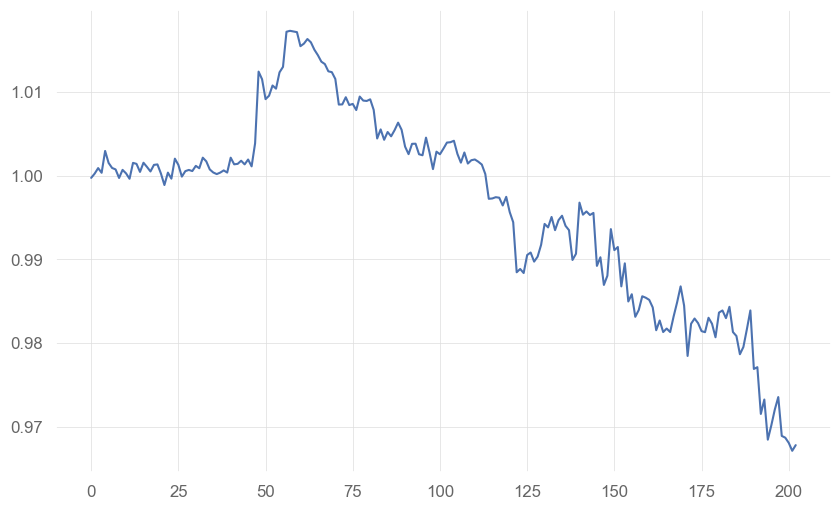

In [82]:
portfolio_returns_series.cumsum().apply(np.exp).plot()

In [85]:
portfolio_rm_instance = Portfolio_RM(portfolio_returns_series)

In [86]:
drawdown_limit, in_drawdown = portfolio_rm_instance.drawdown_limit(-0.15)

In [87]:
in_drawdown

0       False
1       False
2       False
3       False
4       False
        ...  
5141    False
5142    False
5143    False
5144    False
5145    False
Length: 5146, dtype: bool

In [88]:
if in_drawdown.iloc[-1]:
    #Liquidate the portfolio
    symbols_to_liquidate = current_strategy_returns_df.index.get_level_values(1).unique()[-1]
    liquidate(symbols_to_liquidate, exchange)
    #return True

Putting all_together

In [97]:
def perform_portfolio_rm(best_weights, exchange, drawdown_threshold = -0.15):
    """_summary_"""
    current_strategy_returns_df = pd.read_csv('strategy_returns.csv', index_col= [0, 1], parse_dates = ['date'])

    portfolio_returns = np.dot(best_weights, current_strategy_returns_df.T)
    portfolio_returns_series = pd.Series(portfolio_returns)

    portfolio_rm_instance = Portfolio_RM(portfolio_returns_series)

    drawdown_limit, in_drawdown = portfolio_rm_instance.drawdown_limit(drawdown_threshold)

    if in_drawdown.iloc[-1]:
        #Liquidate the portfolio
        print(f'Liquidating the portfolio because in_drawdown in {in_drawdown.iloc[-1]}')
        symbols_to_liquidate = symbols_in_current_balance(exchange)
        liquidate(symbols_to_liquidate, exchange)
        return True
    else :
        print(f'Portfolio is not in drawdown because in drawdown is {in_drawdown.iloc[-1]}')
        return False

In [98]:
perform_portfolio_rm(best_weights, exchange)

Portfolio is not in drawdown because in drawdown is False


False

### Taking Positions

In [31]:
#Get the current_total_balance
current_total_balance = get_portfolio_value(exchange)
current_total_balance

33.3

In [32]:
best_weights

[0.34, 0.33, 0.33]

In [33]:
best_weights = [0.34, 0.33, 0.33]

In [41]:
#Store the max allocation for each strategy in a dictionary
max_allocation_map = {
    key: best_weights[i] * current_total_balance / strategy.max_universe
    for i, (key, strategy) in enumerate(strategy_map.items())
    if i < len(best_weights) and best_weights[i] > 0 and key != 'cash_strat'
}

max_allocation_map

{'mr_strat_1': 2.7472499999999997, 'tf_strat_1': 2.7472499999999997}

In [42]:
#Rebuild the strategy map, with the updated max_allocation for each strategy
for key, value in strategy_map.items():
    if key != 'cash_strat':
        value.max_dollar_allocation = max_allocation_map[key]

In [289]:
sample_results = tf_strat_1.trading_strategy(data, best_params['tf_strat_1'])
sample_results

length of data: 2202


Signal Generated
Position Initialized
Stop Loss Applied
Take Profit Applied
Partial Take Profit Applied
Position Calculated
Manage Trade Applied
All Updated
Costs Applied
Data Downsampled
Coarse Analysis Done
Fine Analysis Done
Universe Updated
In Universe


close  creturns      high  log_return  \
date                                                                    
2024-12-05 20:00:00 BTCUSDT  99072.84  1.513398  99424.00    0.000453   
2024-12-05 21:00:00 BTCUSDT  98908.02  1.510880  99479.72   -0.001665   
2024-12-05 22:00:00 BTCUSDT  96589.04  1.475456  99040.00   -0.023725   
2024-12-05 23:00:00 BTCUSDT  96945.63  1.480903  97457.55    0.003685   
2024-12-06 00:00:00 BTCUSDT  97551.99  1.490166  97757.51    0.006235   
...                               ...       ...       ...         ...   
2025-01-15 05:00:00 ETHUSDT   3224.24  1.000469   3226.50   -0.000698   
2025-01-16 00:00:00 BTCUSDT  96885.50  1.003370  97175.10   -0.002779   
                    ETHUSDT   3224.24  1.000469   3226.50   -0.000698   
2025-01-16 05:00:00 BTCUSDT  96885.50  1.003370  97175.10   -0.002779   
                    ETHUSDT   3224.24  1.000469   3226.50   -0.000698   

                                  low      open        price   returns  \
date                                                                     
2024-12-05 20:00:00 BTCUSDT  97888.00  99028.01  99072.84000  0.000453   
2024-12-05 21:00:00 BTCUSDT  98801.93  99072.84  98908.02000 -0.001664   
2024-12-05 22:00:00 BTCUSDT  90500.00  98908.01  95682.19212 -0.023446   
2024-12-05 23:00:00 BTCUSDT  95340.00  96589.03  96945.63000  0.003692   
2024-12-06 00:00:00 BTCUSDT  95981.72  96945.63  97551.99000  0.006255   
...                               ...       ...          ...       ...   
2025-01-15 05:00:00 ETHUSDT   3216.51   3226.50   3224.24000 -0.000697   
2025-01-16 00:00:00 BTCUSDT  96765.70  97155.10  96885.50000 -0.002775   
                    ETHUSDT   3216.51   3226.50   3224.24000 -0.000697   
2025-01-16 05:00:00 BTCUSDT  96765.70  97155.10  96885.50000 -0.002775   
                    ETHUSDT   3216.51   3226.50   3224.24000 -0.000697   

                                   volume  volume_in_dollars  ...  htf_close  \
date                                                          ...              
2024-12-05 20:00:00 BTCUSDT   5619.976330       5.567870e+08  ...   96945.63   
2024-12-05 21:00:00 BTCUSDT   1883.424160       1.862858e+08  ...   96945.63   
2024-12-05 22:00:00 BTCUSDT  14364.888650       1.387491e+09  ...   96945.63   
2024-12-05 23:00:00 BTCUSDT   4167.053970       4.039777e+08  ...   96945.63   
2024-12-06 00:00:00 BTCUSDT   3693.497580       3.603080e+08  ...   99740.84   
...                                   ...                ...  ...        ...   
2025-01-15 05:00:00 ETHUSDT     60.258220       1.942870e+05  ...    3224.24   
2025-01-16 00:00:00 BTCUSDT     11.885451       1.151528e+06  ...   96885.50   
                    ETHUSDT     60.258220       1.942870e+05  ...    3224.24   
2025-01-16 05:00:00 BTCUSDT     11.885451       1.151528e+06  ...   96885.50   
                    ETHUSDT     60.258220       1.942870e+05  ...    3224.24   

                                htf_volume  htf_volume_in_dollars  \
date                                                                
2024-12-05 20:00:00 BTCUSDT  109921.729662           1.106787e+10   
2024-12-05 21:00:00 BTCUSDT  109921.729662           1.106787e+10   
2024-12-05 22:00:00 BTCUSDT  109921.729662           1.106787e+10   
2024-12-05 23:00:00 BTCUSDT  109921.729662           1.106787e+10   
2024-12-06 00:00:00 BTCUSDT   45049.533100           4.462449e+09   
...                                    ...                    ...   
2025-01-15 05:00:00 ETHUSDT    1539.322589           4.967941e+06   
2025-01-16 00:00:00 BTCUSDT       0.000000           0.000000e+00   
                    ETHUSDT       0.000000           0.000000e+00   
2025-01-16 05:00:00 BTCUSDT       0.000000           0.000000e+00   
                    ETHUSDT       0.000000           0.000000e+00   

                             volume_flag  volume_rank  htf_std_values  \
date                                                                    
2024-12-05 20:00:00 BTCUSDT       

In [109]:
timeframe = '1h'
symbols = ['BTCUSD', 'ETHUSD']
latest = fetch_latest_data(symbols, timeframe).result()

In [110]:
latest

close  creturns      high  log_return  \
date                coin                                               
2025-01-16 05:00:00 BTCUSD  99495.00  0.998917  99603.00   -0.001084   
                    ETHUSD   3372.09  0.999469   3374.99   -0.000531   
                    LTCUSD    118.74  1.002533    119.29    0.002530   

                                 low      open     price   returns  \
date                coin                                             
2025-01-16 05:00:00 BTCUSD  99365.60  99603.00  99495.00 -0.001083   
                    ETHUSD   3367.71   3373.99   3372.09 -0.000531   
                    LTCUSD    117.89    118.14    118.74  0.002533   

                                 volume  volume_in_dollars  
date                coin                                    
2025-01-16 05:00:00 BTCUSD    10.893224       1.083821e+06  
                    ETHUSD   106.270130       3.583524e+05  
                    LTCUSD  1164.425961       1.382639e+05

In [111]:
append_to_csv_with_limit(latest, 'market_data.csv').result()

In [139]:
data = load_data_from_csv('market_data.csv')

In [43]:
data

close  creturns       high  log_return  \
date                coin                                                  
2024-10-25 01:00:00 BTCUSDT   67969.70  0.999712   68010.01   -0.000288   
                    ETHUSDT    2519.50  0.997778    2527.22   -0.002224   
2024-10-25 02:00:00 BTCUSDT   68066.99  1.001143   68080.00    0.001430   
                    ETHUSDT    2522.40  0.998927    2524.80    0.001150   
2024-10-25 03:00:00 BTCUSDT   68008.00  1.000275   68234.34   -0.000867   
...                                ...       ...        ...         ...   
2025-01-16 19:00:00 ETHUSDT    3345.04  0.969175    3345.05    0.005910   
2025-01-16 20:00:00 BTCUSDT  100330.10  0.998345  100600.00    0.000091   
                    ETHUSDT    3337.11  0.966877    3350.06   -0.002373   
2025-01-16 21:00:00 BTCUSDT  100085.00  0.995906  100345.70   -0.002446   
                    ETHUSDT    3332.01  0.965400    3337.02   -0.001529   

                                   low       open      price   returns  \
date                coin                                                 
2024-10-25 01:00:00 BTCUSDT   67845.01   67989.26   67969.70 -0.000288   
                    ETHUSDT    2514.57    2525.09    2519.50 -0.002222   
2024-10-25 02:00:00 BTCUSDT   67836.00   67969.70   68066.99  0.001431   
                    ETHUSDT    2509.89    2519.49    2522.40  0.001151   
2024-10-25 03:00:00 BTCUSDT   67989.55   68066.99   68008.00 -0.000867   
...                                ...        ...        ...       ...   
2025-01-16 19:00:00 ETHUSDT    3320.00    3325.33    3345.04  0.005927   
2025-01-16 20:00:00 BTCUSDT  100286.60  100321.00  100330.10  0.000091   
                    ETHUSDT    3326.29    3343.85    3337.11 -0.002371   
2025-01-16 21:00:00 BTCUSDT  100084.90  100330.10  100085.00 -0.002443   
                    ETHUSDT    3321.22    3336.79    3332.01 -0.001528   

                                  volume  volume_in_dollars  
date                coin                                     
2024-10-25 01:00:00 BTCUSDT   508.337580       3.455155e+07  
                    ETHUSDT  6079.862400       1.531821e+07  
2024-10-25 02:00:00 BTCUSDT   478.050390       3.253945e+07  
                    ETHUSDT  6759.621000       1.705047e+07  
2024-10-25 03:00:00 BTCUSDT   513.745260       3.493879e+07  
...                                  ...                ...  
2025-01-16 19:00:00 ETHUSDT   279.664529       9.354890e+05  
2025-01-16 20:00:00 BTCUSDT   100.354425       1.006857e+07  
                    ETHUSDT   566.902809       1.891817e+06  
2025-01-16 21:00:00 BTCUSDT    21.705221       2.172367e+06  
                    ETHUSDT    69.400235       2.312423e+05  

[4026 rows x 10 columns]

In [44]:
#Run each strategy on enough data points and get the total portfolio value
length_of_data_to_run_strategy = 1000 #This does not have to do with anything with test_size or train_size,
    #but it is better to be equal to the test_size because we want get the latest returns of the strategy with the latest best_params to get the current strategy returns

In [45]:
data_to_run_strategy = data.iloc[-length_of_data_to_run_strategy:]

In [46]:
best_params = {'tf_strat_1': {'std_window': 5, 'mean_window': 10, 'ema_window': 73, 'str_length': 41, 'str_mult': 3, '_min_pos': 0.6947256588850119, '_max_pos': 0.9766155382529169, 'sl_ind_length': 46, 'sl_ind_mult': 4.325173600054098, 'tp_mult': 4, 'ptp_mult': 1.0954101164904113, 'ptp_exit_percent': 0.43373642697843984},
    'mr_strat_1': {'std_window': 5, 'mean_window': 10, 'ema_window': 73, 'hourly_lookback': 1, 'daily_lookback': 3, '_min_pos': 0.6947256588850119, '_max_pos': 0.9766155382529169, 'sl_ind_length': 46, 'sl_ind_mult': 4.325173600054098, 'tp_mult': 4, 'ptp_mult': 1.0954101164904113, 'ptp_exit_percent': 0.43373642697843984},}

In [47]:
current_strategy_results = {
    key: value.trading_strategy(data_to_run_strategy, best_params[key])
    for key, value in strategy_map.items()
    if key != 'cash_strat'
}

Performing Last Days Low Strategy
length of data: 1000
Data:                                  close  creturns       high  log_return  \
date                coin                                                  
2024-12-27 02:00:00 BTCUSDT   96073.77  1.413073   96443.68    0.001633   
                    ETHUSDT    3364.99  1.332611    3388.57    0.000235   
2024-12-27 03:00:00 BTCUSDT   96417.84  1.418133   96443.00    0.003575   
                    ETHUSDT    3379.40  1.338318    3385.60    0.004273   
2024-12-27 04:00:00 BTCUSDT   96300.00  1.416400   96595.98   -0.001223   
...                                ...       ...        ...         ...   
2025-01-16 19:00:00 ETHUSDT    3345.04  0.969175    3345.05    0.005910   
2025-01-16 20:00:00 BTCUSDT  100330.10  0.998345  100600.00    0.000091   
                    ETHUSDT    3337.11  0.966877    3350.06   -0.002373   
2025-01-16 21:00:00 BTCUSDT  100085.00  0.995906  100345.70   -0.002446   
                    ETHUSDT    3332.01 

In [48]:
current_allocation_strategy_map = {
    key: value["coin_amount_to_bought"]
    for key, value in current_strategy_results.items()
    if key != "cash_df"
}

In [86]:
current_allocation_strategy_map['tf_strat_1']

date                        
2024-12-31 21:00:00  BTCUSDT    0.000010
                     ETHUSDT    0.000228
2024-12-31 22:00:00  BTCUSDT    0.000010
                     ETHUSDT    0.000228
2024-12-31 23:00:00  BTCUSDT    0.000010
                                  ...   
2025-01-16 17:00:00  ETHUSDT    0.000182
2025-01-16 18:00:00  BTCUSDT    0.000009
                     ETHUSDT    0.000182
2025-01-16 19:00:00  BTCUSDT    0.000009
                     ETHUSDT    0.000182
Name: coin_amount_to_bought, Length: 766, dtype: float64

In [93]:
current_allocation_results_df = pd.concat(current_allocation_strategy_map, axis=1).fillna(0).sum(axis=1).sort_index()

In [154]:
current_allocation_results_df.loc[current_allocation_results_df.index.get_level_values(0).unique()[-1]]

BTCUSDT    0.000009
ETHUSDT    0.000379
dtype: float64

In [155]:
current_allocation_results_df.index.get_level_values(0).unique()[-1]

Timestamp('2025-01-16 19:00:00')

In [174]:
current_allocation = current_allocation_results_df.loc[current_allocation_results_df.index.get_level_values("date").unique()[-1]]

In [171]:
pd.DataFrame(current_allocation).set_index

<bound method DataFrame.set_index of                 0
BTCUSDT  0.000009
ETHUSDT  0.000379>

In [158]:
last_index = [current_allocation_results_df.index.get_level_values(0).unique()[-1]] * len(current_allocation)

In [165]:
current_allocation

2025-01-16 19:00:00  BTCUSDT    0.000009
                     ETHUSDT    0.000379
dtype: float64

In [175]:
current_allocation.index = pd.MultiIndex.from_tuples(zip(last_index, current_allocation.index), names = ['date', ''])

In [176]:
current_allocation

date                        
2025-01-16 19:00:00  BTCUSDT    0.000009
                     ETHUSDT    0.000379
dtype: float64

In [249]:
list(set(tf_strat_1.current_universe) set(mr_strat_1.current_universe))

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1294110889.py, line 1)

In [251]:
# Extract current universes from selected_strategy
current_universes = [
    set(value.current_universe)  # Convert each universe to a set for comparison
    for key, value in selected_strategy.items()
    if key != 'cash_strat'
]

# Remove overlaps between universes
# Start with the first set and iteratively remove overlaps
unique_universes = []
for universe in current_universes:
    for other_universe in unique_universes:
        universe -= other_universe  # Remove overlapping strings
    unique_universes.append(universe)

# Convert sets back to lists (if needed)
unique_universes = [list(universe) for universe in unique_universes]

flattened_universe = [item for sublist in unique_universes for item in sublist]


In [269]:
flattened_universe

['ETHUSDT', 'BTCUSDT']

<Axes: >

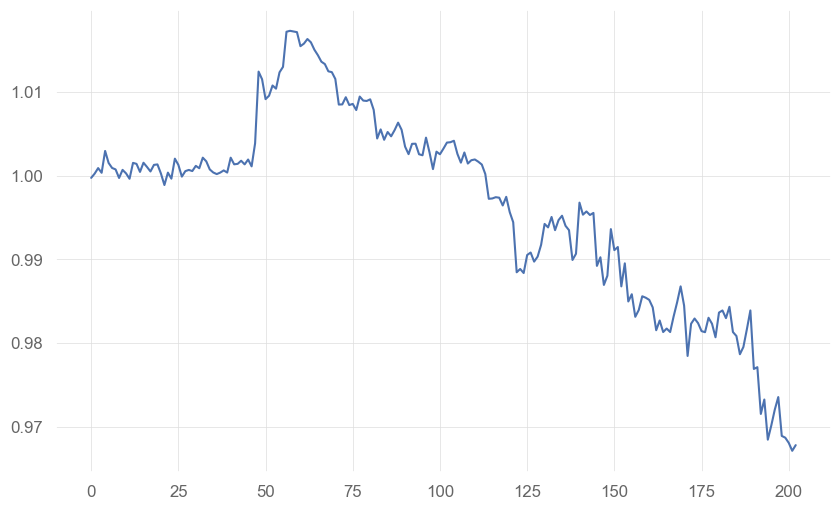

In [257]:
# This will be used to plot the current portfolio 
portfolio_returns = np.dot(best_weights, current_strategy_returns_df.T)
portfolio_cumulative_returns = pd.Series(portfolio_returns).cumsum().apply(np.exp)
portfolio_cumulative_returns.plot()

In [258]:
symbols_in_current_balance = symbols_in_current_balance(exchange)

Symbols in your current balance: ['USDUSDT']


In [259]:
symbols_in_current_balance

In [263]:
# Ensure symbols_in_current_balance is not None
if symbols_in_current_balance:
    symbols_not_in_universe = [
        symbol for symbol in symbols_in_current_balance
        if symbol not in flattened_universe
    ]
    # Liquidate the symbols not in the current universe
    liquidate(symbols_not_in_universe, exchange)
else:
    print("symbols_in_current_balance is None or empty.")


symbols_in_current_balance is None or empty.


In [265]:
def get_coin_balance(coin):
    try:
        balance = exchange.fetch_balance()
        coin_balance = balance['total'][coin]
        return coin_balance
    except Exception as e:
        print(f"Error fetching balance for {coin}: {e}")
        return None

In [266]:
def get_coin_allocation(coin, current_allocation_latest_row):
    return current_allocation_latest_row[coin]

In [274]:
current_allocation['BTCUSDT']

1.1212094059299338

In [ ]:
for coin in flattened_universe:
    formatted_coin = coin.replace('USDT', '').replace('USD', '')
    coin_for_order = coin.replace('USDT', '/USD')

    coin_balance = get_coin_balance(formatted_coin)
    current_coin_allocation = current_allocation[coin]
    
    to_add = current_coin_allocation - coin_balance
    
    if to_add > 0:
        print(f"Adding {to_add} {formatted_coin} to the portfolio...")
        buy(to_add, coin_for_order, exchange)
    elif to_add < 0:
        print(f"Selling {-to_add} {formatted_coin} from the portfolio...")
        sell(-to_add, coin_for_order, exchange)

Selling 1.191325442369189 ETH from the portfolio...
Error: kraken {"error":["EOrder:Insufficient funds"]}
Selling 0.8787905940700662 BTC from the portfolio...
Error: kraken {"error":["EOrder:Insufficient funds"]}


Putting Everything Together

In [ ]:
def run_strategy(exchange, halal_symbols, selected_strategy, best_params, best_weights, timeframe = '1h'):
    #Get the current_total_balance
    current_total_balance = get_portfolio_value(exchange)

    #Store the max allocation for each strategy in a dictionary
    max_allocation_map = {
        key: best_weights[i] * current_total_balance / strategy.max_universe
        for i, (key, strategy) in enumerate(selected_strategy.items())
        if i < len(best_weights) and best_weights[i] > 0 and key != 'cash_strat'
    }

    #Rebuild the strategy map, with the updated max_allocation for each strategy
    for key, value in selected_strategy.items():
        if key != 'cash_strat':
            value.max_dollar_allocation = max_allocation_map[key]
            
    
    timeframe = timeframe
    latest = fetch_latest_data(halal_symbols, timeframe).result()
    append_to_csv_with_limit(latest, 'market_data.csv').result()
    data = load_data_from_csv('market_data.csv')
    
    
    #Run each strategy on enough data points and get the total portfolio value
    length_of_data_to_run_strategy = 100 #This does not have to do with anything with test_size or train_size,
        #but it is better to be equal to the test_size because we want get the latest returns of the strategy with the latest best_params to get the current strategy returns
    data_to_run_strategy = data.iloc[-length_of_data_to_run_strategy:]
    
    current_strategy_results = {
        key: value.trading_strategy(data_to_run_strategy, best_params[key])
        for key, value in selected_strategy.items()
        if key != 'cash_strat'
    }
    
    current_allocation_strategy_map = {
        key: value['current_allocation']
        for key, value in current_strategy_results.items()
        if key != 'cash_strat'
    }
    
    current_allocation_results_df = pd.concat(current_allocation_strategy_map, axis=1).fillna(0).sum(axis=1)
    
    current_allocation = get_last_row(current_allocation_results_df)
    
    current_universe = list(
        set(
            value.current_universe
            for value in selected_strategy.values()
            if key != 'cash_strat'
        )
    )

    symbols_in_current_balance = symbols_in_current_balance(exchange)
    # Find symbols in current balance but not in current universe
    symbols_not_in_universe = [symbol for symbol in symbols_in_current_balance if symbol not in current_universe]

    # Liquidate the symbols not in the current universe
    print(f"Liquidating {symbols_not_in_universe}...")
    liquidate(symbols_not_in_universe, exchange)
    print("Liquidation complete.")

    for coin in current_universe:
        formatted_coin = coin.replace('USDT', '')
        coin_balance = get_coin_balance(formatted_coin)
        current_coin_allocation = get_coin_allocation(coin, current_allocation)
        
        to_add = current_coin_allocation - coin_balance
        
        if to_add > 0:
            print(f"Adding {to_add} {formatted_coin} to the portfolio...")
            buy(to_add, coin, exchange)
        elif to_add < 0:
            print(f"Selling {-to_add} {formatted_coin} from the portfolio...")
            sell(-to_add, coin, exchange)
            
    # This will be used to plot the current portfolio 
    portfolio_returns = np.dot(best_weights, current_strategy_returns_df.T)
    portfolio_cumulative_returns = portfolio_returns.cumsum().apply(np.exp)
    portfolio_cumulative_returns.plot()

In [ ]:
run_strategy(exchange, symbols, selected_strategy, best_params, best_weights, timeframe = '1h')

---

### Loop

In [26]:
# OUTSIDE OF METHOD:
upload_complete_market_data(halal_symbols, data_size=(train_size + test_size) * 4)
strategy_data_filename = 'strategy_data.csv'
market_data_filename = 'market_data.csv'
data = load_data_from_csv(market_data_filename)
strat_1_instance = Last_Days_Low(data, objective='multiple', train_size=train_size, test_size=test_size, step_size=step_size)
strat_2_instance = Sprtrnd_Breakout(data, objective='multiple', train_size=train_size, test_size=test_size, step_size=step_size)

counter = 0
cash_df = pd.DataFrame(data={'strategy': np.zeros(data.shape[0]), 'portfolio_value': np.ones(data.shape[0])}, index=data.index)
strategy_map = {
    'cash_strat': cash_df,
    'strat_1': strat_1_instance,
    'strat_2': strat_2_instance
}
best_params = None
best_weights = None
exchange = ccxt.kraken({
    'apiKey': api_key,
    'secret': api_secret
})
# halal_symbols = get_halal_symbols()
halal_symbols = ['BTCUSD', 'ETHUSD', 'LTCUSD']
symbols_to_liquidate = None
selected_strategy = None
drawdown_threshold = -0.15
train_size = 440
test_size = 200
step_size = 200
low_corr_thresh = 1.0
max_rows_market_data = market_data_size = 2000
timeframe = '1h'

strategy_optimization_frequency = 24  # Every 24 hours
portfolio_optimization_frequency = 24  # Every 24 hours
portfolio_management_frequency = 24  # Every 24 hours

# BEFORE THE MAIN LOOP
upload_complete_market_data(halal_symbols, data_size=train_size + test_size)

# THE MAIN LOOP
while True:
    now = dt.datetime.now()
    next_hour = (now + dt.timedelta(minutes=1)).replace(second=0, microsecond=0)
    sleep_duration = (next_hour - now).total_seconds()
    time.sleep(sleep_duration)
    data = load_data_from_csv(market_data_filename)

    if counter % strategy_optimization_frequency == 0:
        best_params = perform_optimization(strategy_map)

    if counter % portfolio_optimization_frequency == 0:
        best_weights = perform_portfolio_optimization(strategy_map, train_size=train_size, test_size=test_size, step_size=step_size)

    if counter % portfolio_management_frequency == 0:
        selected_strategy = perform_portfolio_management(strategy_map, low_corr_threshold=low_corr_thresh)

    if perform_portfolio_rm(best_weights, exchange, drawdown_threshold=drawdown_threshold):
        continue

    run_strategy(exchange, halal_symbols, selected_strategy, best_params, best_weights, timeframe=timeframe)
    
    counter += 1

NameError: name 'upload_complete_market_data' is not defined

Final Test

In [3]:
import ccxt
import pandas as pd
import numpy as np
import os
import time
from unsync import unsync
import datetime as dt
import sys
from concurrent.futures import ThreadPoolExecutor
import re
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'Data_Management')))
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'Portfolio_Optimization')))
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'Strategies', 'Trend_Following')))
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'Strategies', 'Mean_Reversion')))

# Import the modules
from data import Data, get_halal_symbols
from fetch_symbols import get_symbols
from sprtrnd_breakout import Sprtrnd_Breakout
from last_days_low import Last_Days_Low
from portfolio_management import Portfolio_Management
from portfolio_optimization import Portfolio_Optimization
from portfolio_risk_management import Portfolio_RM



class Deploy():
    def __init__(self, train_size = 500, test_size = 500, step_size = 500):
        self.api_key = 'yqPWrtVuElaIExKmIp/E/upTOz/to1x7tC3JoFUxoSTKWCOorT6ifF/B'
        self.api_secret = 'L8h5vYoAu/jpQiBROA9yKN41FGwZAGGVF3nfrC5f5EiaoF7VksruPVdD7x1VOwnyyNCMdrGnT8lP4xHTiBrYMQ=='
        self.exchange = ccxt.kraken({
            'apiKey': self.api_key,
            'secret': self.api_secret
        })
        self.train_size = train_size
        self.test_size = test_size
        self.step_size = step_size
        self.low_corr_thresh = 1.0
        self.market_data_filename = 'market_data.csv'
        self.strategy_data_filename = 'strategy_returns.csv'
        self.timeframe = '1h'
        self.best_params = None
        self.best_weights = None
        data = self.load_data_from_csv()
        strat_1_instance = Last_Days_Low(data, objective='multiple', train_size=train_size, test_size=test_size, step_size=step_size)
        strat_2_instance = Sprtrnd_Breakout(data, objective='multiple', train_size=train_size, test_size=test_size, step_size=step_size)
        live_strat_1_instance = Last_Days_Low(data, objective='multiple', train_size=train_size, test_size=test_size, step_size=step_size, live = True)
        live_strat_2_instance = Sprtrnd_Breakout(data, objective='multiple', train_size=train_size, test_size=test_size, step_size=step_size, live = True)
        # self.halal_symbols = get_halal_symbols()
        self.halal_symbols = ['BTCUSD', 'ETHUSD']
        self.cash_df = pd.DataFrame(data={'strategy': np.zeros(data.shape[0]), 'portfolio_value': np.ones(data.shape[0])}, index=data.index)
        self.strategy_map = {
            'cash_strat': self.cash_df,
            'strat_1': strat_1_instance,
            'strat_2': strat_2_instance
        }
        self.live_strategy_map = {
            'cash_strat': self.cash_df,
            'strat_1': live_strat_1_instance,
            'strat_2': live_strat_2_instance
        }
        self.strategy_optimization_frequency = self.step_size
        self.portfolio_optimization_frequency = 300 #Every 2 Weeks
        self.portfolio_management_frequency = 4400 #Around 6 months
        self.counter = 0
        self.best_params = None
        self.best_weights = None
        self.symbols_to_liquidate = None
        self.selected_strategy = None
        self.live_selected_strategy = None
        self.data_instance = None
        self.drawdown_threshold = -0.15
        self.max_rows_market_data = self.market_data_size = 2000
        self.length_of_data_to_run_strategy = 500
        
    
    ############ Helper Methods ############
    def symbols_in_current_balance(self):
        # Fetch account balance
        try:
            balance = self.exchange.fetch_balance()

            # Extract symbols with non-zero balance
            symbols = [
                f'{currency}USDT'
                for currency, info in balance['total'].items()
                if info > 0
            ]

            print("Symbols in your current balance:", symbols)
        except ccxt.BaseError as e:
            print(f"An error occurred: {e}")
    def get_coin_balance(self, formatted_coin):
        try:
            balance = self.exchange.fetch_balance()
            return balance['total'][formatted_coin] if balance['total'][formatted_coin] is not None else 0
        except Exception as e:
            print(f"Error fetching balance for {formatted_coin}: {e}")
            return None
        
    
    def get_usd_left(self):
        return self.exchange.fetch_balance()['free']['USD']
            
    def buy(self, to_add, coin):
        try:
            
            order = self.exchange.create_market_buy_order(coin, to_add)
            print(f"Buy order placed: {order}")
        except Exception as e:
            print(f"Error: {e}")
            
    def sell(self, to_sell, coin):
        try:
            order = self.exchange.create_market_sell_order(coin, to_sell)
            print(f"Sell order placed: {order}")
        except Exception as e:
            print(f"Error: {e}")
            
    def liquidate(self, symbols_to_liquidate):
        try:
            # Step 1: Get your balances
            balance = self.exchange.fetch_balance()
            cant_liquidate = ['USD', 'CAD']

            # Step 2: Loop through all assets in your balance and sell them
            for coin, coin_balance in balance['free'].items():
                if coin in symbols_to_liquidate and coin not in cant_liquidate:
                    if coin_balance > 0:  # Only sell if you have a non-zero balance
                        print(f"Selling {coin_balance} {coin}...")

                        # Determine the symbol for the sell order (e.g., BTC/USD, ETH/USDT)
                        symbol = f"{coin}/USD"  # Replace USD with your preferred quote currency
                        order = self.exchange.create_market_sell_order(symbol, coin_balance)
                        print(f"Sell order placed: {order}")
                    else:
                        print(f"No {coin} to sell.")

            print("All possible assets have been liquidated.")

        except Exception as e:
            print(f"Error: {e}")
    
    def get_portfolio_value(self):
        try:
            # Fetch account balances
            balances = self.exchange.fetch_balance()

            # Fetch tickers to get the latest prices
            tickers = self.exchange.fetch_tickers()

            # Calculate portfolio value in USD (or another base currency)
            portfolio_value = 0.0

            for currency, balance in balances['total'].items():
                if balance > 0:
                    if currency == "USD":
                        # Add USD cash directly to portfolio value
                        portfolio_value += balance
                    else:
                        # Use the USD pair or the most liquid market
                        pair = f"{currency}/USD"
                        if pair in tickers:
                            price = tickers[pair]['last']
                            portfolio_value += balance * price
            return round(portfolio_value, 2)

        except ccxt.BaseError as e:
            print(f"An error occurred: {str(e)}")
            return None
        
    def format_symbols(self, symbols):
        """Converts the symbols to a format that the exchange understands."""
        if symbols[0].endswith('T'):
            symbols = [s[:-1] for s in symbols]
        return [symbol.replace("USD", "/USD") for symbol in symbols]

    def filter_halal_df(self, data):
        return data[data.index.get_level_values("coin").isin(self.halal_symbols)]
    

    ############ Main Methods ############
    def upload_complete_market_data(self, data_size = 2200):
        start_time = (dt.datetime.now() - dt.timedelta(hours= self.max_rows_market_data)).date()
        end_time = dt.datetime.now().date()
        timeframes = ['1w', '1d', '4h', '1h', '30m','15m', '5m', '1m']
        index = 3 #It is better to choose the highest frequency for the backtest to be able to downsample
        interval = timeframes[index]
        self.data_instance = Data(self.halal_symbols, interval, start_time, end_time, exchange = 'kraken')
        data = self.data_instance.df
        last_date_data = data.index.get_level_values(0).unique()[-1].tz_localize('UTC')
        
        if dt.datetime.now(dt.UTC).replace(minute=0, second=0, microsecond=0) != last_date_data:
            time_difference = dt.datetime.now(dt.UTC).replace(minute=0, second=0, microsecond=0) - last_date_data
            hours_difference = time_difference.total_seconds() / 3600 # Get the number of hours
            missing_data = self.fetch_latest_data(limit = int(hours_difference) + 1)
            complete_data = pd.concat([data, missing_data])
            
        complete_data.index = complete_data.index.set_levels(pd.to_datetime(complete_data.index.levels[0]), level=0)
        complete_data.to_csv('market_data.csv')
        print('Market data updated successfully')    

    def fetch_latest_data(self, limit=2):
        """Fetch latest OHLCV data for multiple symbols and stack them into a single DataFrame."""
        
        formatted_symbols = self.format_symbols(self.halal_symbols)
        
        def fetch_symbol_data(symbol, formatted_symbol):
            """Fetch data for a single symbol and return a DataFrame."""
            try:
                ohlcv = self.exchange.fetch_ohlcv(symbol, self.timeframe, limit=limit)
                df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
                df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
                df.set_index('timestamp', inplace=True)
                df['coin'] = symbol
                return df
            except Exception as e:
                print(f"Error fetching data for {symbol}: {e}")
                try:
                    # Retry fetching data
                    ohlcv = self.exchange.fetch_ohlcv(formatted_symbol, self.timeframe, limit=limit)
                    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
                    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
                    df.set_index('timestamp', inplace=True)
                    df['coin'] = formatted_symbol
                    return df
                except Exception as e:
                    print(f"Error fetching data for {symbol} on retry: {e}")
                    return pd.DataFrame()

        # Use ThreadPoolExecutor for parallel requests
        with ThreadPoolExecutor(max_workers=16) as executor:  # Adjust workers based on CPU
            results = list(executor.map(fetch_symbol_data, self.halal_symbols, formatted_symbols))

        # Concatenate all DataFrames and set multi-level index
        data_frames = [df for df in results if not df.empty]
        if data_frames:
            stacked_df = pd.concat(data_frames)
            stacked_df.set_index('coin', append=True, inplace=True)
            stacked_df = stacked_df[~stacked_df.index.duplicated()]  # Remove duplicates
            df = self.data_instance.prepare_data(stacked_df.unstack())
            df.reset_index(level = 1, inplace = True)
            df['coin'] = df['coin'].str.replace('/USD', 'USDT', regex=False)
            df.set_index('coin', append = True, inplace = True)
            return df
        else:
            return pd.DataFrame()  # Return an empty DataFrame if no data
            
        # Append new data to CSV and maintain max length (asynchronous)
    def append_to_csv_with_limit(self, filename, latest, use_limit = True, last_row = True):
        """_summary_

        Args:
            data (_type_): _description_
            filename (_type_): _description_
            max_rows (int, optional): _description_. Defaults to 2202. Should be account for the max number of rows needed for any of the processes
        """
        file_exists = os.path.isfile(filename)
        
        if len(latest) == 0:
            print('No data to append', latest)
            return
        latest_data = latest.loc[latest.index.get_level_values(0).unique()[-1]]
        last_index = [latest.index.get_level_values(0).unique()[-1]] * len(latest_data)
        latest_data.index = pd.MultiIndex.from_tuples(zip(last_index, latest_data.index), names = ['date', ''])
        
        if file_exists:
            existing_df = pd.read_csv(filename, index_col=[0, 1], parse_dates=['date'])
            print(existing_df.index.get_level_values(0).unique()[-1])
            print(latest.index.get_level_values(0).unique()[-1])
            print(latest)
            if existing_df.index.get_level_values(0).unique()[-1] == latest.index.get_level_values(0).unique()[-1]:
                return
            
            if last_row:
                combined_df = pd.concat([existing_df, latest_data])
            else:
                combined_df = pd.concat([existing_df, latest])

            if len(combined_df) > self.max_rows_market_data and use_limit:
                combined_df = combined_df.iloc[-self.max_rows_market_data:]  # Keep only the last max_rows rows
            combined_df.to_csv(filename)
        else:
            print('File does not exist')
            latest.to_csv(filename, mode='w', header=True)
            
    #Getting the data from csv
    def load_data_from_csv(self):
        filename = self.market_data_filename
        if os.path.isfile(filename):
            data = pd.read_csv(filename, index_col=[0, 1], parse_dates=['date'])
            if len(data) >= self.train_size + self.test_size:
                return data
        else:
            return pd.DataFrame()
    
    def perform_portfolio_rm(self):
        
        if os.path.isfile(self.strategy_data_filename):
            current_strategy_returns_df = pd.read_csv(self.strategy_data_filename, index_col=[0, 1], parse_dates=['date'])
        else:
            return False

        if current_strategy_returns_df.empty or len(current_strategy_returns_df) < self.train_size + self.test_size:
            return False
        portfolio_returns = np.dot(self.best_weights, current_strategy_returns_df.T)
        portfolio_returns_series = pd.Series(portfolio_returns)
        portfolio_returns_series.cumsum().apply(np.exp).plot()

        portfolio_rm_instance = Portfolio_RM(portfolio_returns_series)

        drawdown_limit, in_drawdown = portfolio_rm_instance.drawdown_limit(self.drawdown_threshold)

        if in_drawdown.iloc[-1]:
            #Liquidate the portfolio
            print(f'Liquidating the portfolio because in_drawdown in {in_drawdown.iloc[-1]}')
            symbols_to_liquidate = self.symbols_in_current_balance()
            self.liquidate(symbols_to_liquidate)
            return True
        else :
            print(f'Portfolio is not in drawdown because in drawdown is {in_drawdown.iloc[-1]}')
            return False
    
    def run_wfo_and_get_results_returns(self):
        """_summary_
        Takes the strategy map, runs the WFO for each strategy and returns the results of the strategy returns after the WFO.
        It also adds the df of the strategy returns to a csv file

        Args:
            strategy_map (_type_): _description_

        Returns:
            results_strategy_returns (_type_): _description_ the results of the strategy returns after the WFO
        """
        #Run the WFO for each strategy (but the cash strategy)
        for key, value in self.strategy_map.items():
            if key != 'cash_strat':
                value.test()
                
        #Make a new dictionary that contains the results strategy returns of the WFO
        results_strategy_returns = {}
        for key, value in self.strategy_map.items():
            if key != 'cash_strat':
                results_strategy_returns[key] = value.results.strategy
            elif key == 'cash_strat':
                results_strategy_returns[key] = value.strategy
        
        return results_strategy_returns
            
    def perform_portfolio_management(self):
        """_summary_

        Args:
            strategy_map (_type_): _description_
            low_corr_threshold (int, optional): _description_. Defaults to 1.
        """
        results_strategy_returns = self.run_wfo_and_get_results_returns()

        portfolio_management = Portfolio_Management(results_strategy_returns)

        keys_for_selected_strategy = portfolio_management.filter_by_correlation(low_corr_threshold= self.low_corr_thresh).columns

        self.selected_strategy = {key: value for key, value in self.strategy_map.items() if key in keys_for_selected_strategy}
        
        self.live_selected_strategy = {key: value for key, value in self.live_strategy_map.items() if key in keys_for_selected_strategy}
        
    def perform_optimization(self):
        """_summary_

        Args:
            strategy_map (_type_): _description_
        """

        #Run the optimization to get the strategy parameters
        for key, value in self.strategy_map.items():
            if key != 'cash_strat':
                value.optimize()

        #Storing the best_params for each strategy in a separate dictionary
        self.best_params = {key: value.best_params for key, value in self.strategy_map.items() if key != 'cash_strat'}
        
    def perform_portfolio_optimization(self):
        """_summary_

        Args:
            strategy_returns_df (_type_): _description_
            train_size (int, optional): _description_. Defaults to 1000.
            test_size (int, optional): _description_. Defaults to 1000.
            step_size (int, optional): _description_. Defaults to 1000.
        """
        results_strategy_returns = self.run_wfo_and_get_results_returns()
        
        #Get portfolio optimization instance
        portfolio_optimization_instance = Portfolio_Optimization(log_rets = results_strategy_returns, train_size = self.train_size, test_size = self.test_size, step_size = self.step_size, objective = 'multiple')

        #Run the 
        results_strategy_returns_df = pd.concat(results_strategy_returns, axis = 1).fillna(0)
        train_data = results_strategy_returns_df.iloc[-self.train_size:]
        self.best_weights = portfolio_optimization_instance.optimize_weights_minimize(train_data)
    
    def run_strategy(self):
        #Get the current_total_balance
        current_total_balance = self.get_portfolio_value()

        #Store the max allocation for each strategy in a dictionary
        max_allocation_map = {
            key: self.best_weights[i] * current_total_balance / strategy.max_universe
            for i, (key, strategy) in enumerate(self.selected_strategy.items())
            if i < len(self.best_weights) and self.best_weights[i] > 0 and key != 'cash_strat'
        }

        #Rebuild the strategy map, with the updated max_allocation for each strategy
        for key, value in self.live_selected_strategy.items():
            if key != 'cash_strat':
                value.max_dollar_allocation = max_allocation_map[key]
                
        latest = self.fetch_latest_data()
        self.append_to_csv_with_limit(self.market_data_filename, latest)
        data = self.load_data_from_csv()
        
        
        #Run each strategy on enough data points and get the total portfolio value
        data_to_run_strategy = data.unstack().iloc[-self.length_of_data_to_run_strategy:].stack(future_stack = True)
        print(data_to_run_strategy)
        
        current_strategy_results = {
            key: value.trading_strategy(data_to_run_strategy, self.best_params[key])
            for key, value in self.live_selected_strategy.items()
            if key != 'cash_strat'
        }
    
        current_strategy_returns = {
            key: value['strategy']
            for key, value in current_strategy_results.items()
        }
        
        current_strategy_returns['cash_strat'] = self.cash_df['strategy']
        
        #Append current strategy results to the csv file for future analysis
        current_strategy_returns_df = pd.concat(current_strategy_returns, axis=1).fillna(0)
        print(current_strategy_returns_df)
        self.append_to_csv_with_limit(self.strategy_data_filename, current_strategy_returns_df, use_limit = False, last_row = False)
        
        current_allocation_strategy_map = {
            key: value['coin_amount_to_bought']
            for key, value in current_strategy_results.items()
            if key != 'cash_strat'
        }
        
        current_allocation_results_df = pd.concat(current_allocation_strategy_map, axis=1).fillna(0).sum(axis=1).sort_index()
        current_allocation = current_allocation_results_df.loc[current_allocation_results_df.index.get_level_values("date").unique()[-1]]
        
        
        # Extract current universes from selected_strategy
        current_universes = [
            set(value.current_universe)  # Convert each universe to a set for comparison
            for key, value in self.live_selected_strategy.items()
            if key != 'cash_strat'
        ]

        # Remove overlaps between universes
        # Start with the first set and iteratively remove overlaps
        unique_universes = []
        for universe in current_universes:
            for other_universe in unique_universes:
                universe -= other_universe  # Remove overlapping strings
            unique_universes.append(universe)

        # Convert sets back to lists (if needed)
        unique_universes = [list(universe) for universe in unique_universes]

        flattened_universe = [item for sublist in unique_universes for item in sublist]


        symbols_in_current_balance = self.symbols_in_current_balance()
        
        # Ensure symbols_in_current_balance is not None
        if symbols_in_current_balance:
            symbols_not_in_universe = [
                symbol for symbol in symbols_in_current_balance
                if symbol not in flattened_universe
            ]
            print(f"Liquidating {symbols_not_in_universe}...")
            self.liquidate(symbols_not_in_universe)
            print("Liquidation complete.")
        else:
            print("symbols_in_current_balance is None or empty.")

        for coin in flattened_universe:
            formatted_coin = coin.replace('USDT', '').replace('USD', '')
            coin_for_order = coin.replace('USDT', '/USD')
            coin_balance = self.get_coin_balance(formatted_coin)
            current_coin_allocation = current_allocation[coin]
            
            # to_add = round(current_coin_allocation - coin_balance, 7)
            to_add = self.get_usd_left() / 2 #Just to test
            
            if to_add > 0 and to_add < self.get_usd_left():
                print(f"Adding {to_add} {formatted_coin} to the portfolio...")
                self.buy(to_add, coin_for_order)
            elif to_add < 0 and coin_balance >= abs(to_add):
                print(f"Selling {-to_add} {formatted_coin} from the portfolio...")
                self.sell(-to_add, coin_for_order)
            
        
    def main_loop(self):
        # THE MAIN LOOP
        while True:

            if self.counter % self.strategy_optimization_frequency == 0:
                print('Performing optimization')
                self.perform_optimization()

            if self.counter % self.portfolio_optimization_frequency == 0:
                print('Performing portfolio optimization')
                self.perform_portfolio_optimization()

            if self.counter % self.portfolio_management_frequency == 0:
                print('Performing portfolio management')
                self.perform_portfolio_management()
            
            print('Adding to counter')
            self.counter += 1

            if self.perform_portfolio_rm():
                print('Performed portfolio risk management, portfolio is in drawdown')
                now = dt.datetime.now()  # Skip running the strategy, go straight to time update
                print('Current time: ', now)
                next_hour = (now + dt.timedelta(hours=1)).replace(minute = 0, second=0, microsecond=0)
                print('Next hour: ', next_hour)
                sleep_duration = (next_hour - now).total_seconds()
                print('Sleep duration: ', sleep_duration)
                time.sleep(sleep_duration)
                continue  # Skip the strategy execution and restart the loop
            else:
                print('Portfolio is not in drawdown')
            

            #Perform the strategy after each hour
            now = dt.datetime.now()
            print('Current time: ', now)
            next_hour = (now + dt.timedelta(minutes=1)).replace(second=0, microsecond=0)
            print('Next hour: ', next_hour)
            sleep_duration = (next_hour - now).total_seconds()
            print('Sleep duration: ', sleep_duration)
            time.sleep(sleep_duration)
            
            print('Running strategy')
            self.run_strategy()

In [4]:
deploy_instance = Deploy()

In [5]:
deploy_instance.upload_complete_market_data()

Error fetching data for BTCUSD: kraken does not have market symbol BTCUSD
Error fetching data for ETHUSD: kraken does not have market symbol ETHUSD
Market data updated successfully


In [ ]:
deploy_instance.main_loop()

Performing optimization
Performing Last Days Low Strategy
length of data: 500
Data:                                  close  creturns       high  log_return  \
date                coin                                                  
2025-01-06 15:00:00 BTCUSDT  102147.95  1.502413  102468.92    0.013909   
                    ETHUSDT    3714.45  1.471005    3714.49    0.007833   
2025-01-06 16:00:00 BTCUSDT  102158.67  1.502570  102480.00    0.000105   
                    ETHUSDT    3710.18  1.469314    3744.83   -0.001150   
2025-01-06 17:00:00 BTCUSDT  101831.95  1.497765  102158.68   -0.003203   
...                                ...       ...        ...         ...   
2025-01-16 22:00:00 ETHUSDT    3295.59  0.954848    3318.56   -0.006946   
2025-01-16 23:00:00 BTCUSDT   99976.70  0.994829  100048.60    0.001669   
                    ETHUSDT    3307.25  0.958226    3308.99    0.003532   
2025-01-17 00:00:00 BTCUSDT  100200.00  0.997051  100338.70    0.002231   
                